# COLLLISION PROBABILITY USING STACKING REGRESSION
This notebook corresponds to Jokin Cuesta's Master's Thesis for the Master's Degree in Data Science at the UOC. In this notebook, the best model studied in the section 2 will be used to calculate the collision probability.

Some of the code is inspired in Rafael Corvillo´s thesis (https://github.com/rcorvial/vehicles_collision_detector). This code is referenced in each cell as (RC)

# 1. Load libraries and datasets

In [ ]:
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import pickle
import random
import time
import os
import time

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# Load the datasets (RC)
DATASETS_FOLDER = os.path.join("TFM", "datasets")
POSITIONS_FILE = os.path.join(DATASETS_FOLDER, "positions.csv")
df = pd.read_csv(POSITIONS_FILE)

columns = ['time(s)', 'vehicle_id', 'latitude(m)', 'longitude(m)', 'heading']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])

# Load scaled dataset
DATASETS_FOLDER = os.path.join("TFM", "datasets")
SCALED_FILE = os.path.join(DATASETS_FOLDER, "scaled_dataset.csv")
df_scaled = pd.read_csv(SCALED_FILE)

# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join(DATASETS_FOLDER, "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

# Load dataset with vehicles colision
DATASET_COL = os.path.join(DATASETS_FOLDER, "collision.csv")
df_col = pd.read_csv(DATASET_COL)
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

# Load dataset with vehicles no-colision
DATASET_NOCOL = os.path.join(DATASETS_FOLDER, "no_collision.csv")
df_nocol = pd.read_csv(DATASET_NOCOL)
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,10522,10561
1,10480,10571
2,10423,10532
3,10490,10500
4,10475,10549


In [ ]:
# RC
from sklearn.preprocessing import MinMaxScaler
import pickle
# Load MinMaxScaler for target variables
MINMAXSCALER_FILE = os.path.join("TFM", "implementation",
                                 "data_preparation", "minmaxscaler.pkl")
with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
  minmaxscaler = pickle.load(f_minmaxscaler)

#2. Calculation of collision probability

In [ ]:
def get_rotated_points(coordinates, bearing, width, length): # (RC)
  """
  Fit and predict using a stacked regression model with multiple base models.

  Parameters:
      base_models (list): List of base regression models.
      meta_model: Meta regression model used to combine the predictions of the base models.
      t (int): Number of future steps to predict.
      num (int): Number of previous steps to consider for prediction.
      array (numpy array): Array of previous steps' values.

  Returns:
      numpy array: Array of predicted values for the next t steps.
  """
  start = geopy.Point(coordinates)
  width = width/1000
  length = length/1000
  rectlength = geopy.distance.distance(kilometers=length)
  rectwidth = geopy.distance.distance(kilometers=width)
  halfwidth = geopy.distance.distance(kilometers=width/2)
  halflength = geopy.distance.distance(kilometers=length/2)

  pointAB = halflength.destination(point=start, bearing=bearing)
  pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
  pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
  pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
  pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

  points = []
  for point in [pointA, pointB, pointC, pointD]:
    coords = (point.latitude, point.longitude)
    points.append(coords)

  return points


def get_collision(v1_id, v2_id, v1_coords, v2_coords, dimensions): # (RC)
  colision = 0

  v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
  v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]
  v1_points = get_rotated_points(tuple(v1_coords[:2]), v1_coords[2],
                                 v1_width, v1_length)
  polygon1 = geometry.Polygon(v1_points)

  v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
  v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]
  v2_points = get_rotated_points(tuple(v2_coords[:2]), v2_coords[2],
                                 v2_width, v2_length)
  polygon2 = geometry.Polygon(v2_points)

  if polygon1.intersection(polygon2).area > 0.0:
    colision = 1

  return colision


def calculate_variance(values): # (RC)
    # Calculate the mean of the values
    mean = np.mean(values)

    # Calculate the variance by summing the squared differences
    # between each value and the mean, and dividing by the number of values
    variance = np.sum((values - mean) ** 2) / len(values)

    return variance


def calculate_covariance(values1, values2): # (RC)
    # Calculate the means of the values
    mean1 = np.mean(values1)
    mean2 = np.mean(values2)

    # Calculate the covariance by summing the products of the differences
    # between each pair of values and the means, and dividing by the number of values
    covariance = np.sum((values1 - mean1) * (values2 - mean2)) / len(values1)

    return covariance


def calculate_covariance_matrix(latitudes, longitudes, thetas): # (RC)
    # Calculate the variance of the coordinates and orientation
    # var_lat = calculate_variance(latitudes) # or np.var(latitudes)
    # var_long = calculate_variance(longitudes) # or np.var(longitudes)
    # var_theta = calculate_variance(thetas)  # or np.var(thetas)
    var_lat = np.var(latitudes)
    var_long = np.var(longitudes)
    var_theta = np.var(thetas)

    # Calculate the covariance between the coordinates and orientation
    cov_latlong = calculate_covariance(latitudes, longitudes)
    cov_lattheta = calculate_covariance(latitudes, thetas)
    cov_longtheta = calculate_covariance(longitudes, thetas)

    # Return the covariance matrix
    return np.array([[var_lat, cov_latlong, cov_lattheta],
                     [cov_latlong, var_long, cov_longtheta],
                     [cov_lattheta, cov_longtheta, var_theta]])


def calculate_pdf(y_pred): # (RC)
    # Calculate the mean position of the vehicle based on its coordinates and orientation
    mean = [np.mean(y_pred[:, 0]), np.mean(y_pred[:, 1]), np.mean(y_pred[:, 2])]

    # Calculate the covariance matrix of the vehicle's position based on its coordinates and orientation
    covariance = calculate_covariance_matrix(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])

    # Return the probability density function for the vehicle
    return scipy.stats.multivariate_normal(mean=mean, cov=covariance,
                                           allow_singular=True)


def collision_probability(y_pred1, y_pred2, num_samples=1000): # (RC)
  # Calculate the probability density function for both vehicles
  pdf1 = calculate_pdf(y_pred1)
  pdf2 = calculate_pdf(y_pred2)

  # Generate random samples for the positions of both vehicles
  samples1 = pdf1.rvs(size=num_samples)
  samples2 = pdf2.rvs(size=num_samples)

  # Calculate the number of samples where the vehicles are closer
  collisions = 0
  for i in range(num_samples):
    # Check if there is collision between the vehicles
    if get_collision(v1_id, v2_id, samples1[i], samples2[i], df_dim):
      collisions += 1

  # Return the fraction of samples where the vehicles collide
  return collisions / num_samples


def fit_and_pred_stack_list(base_models, meta_model, t, num, array):
    """
    Fit and predict using a stacked regression model with multiple base models.

    Parameters:
        base_models (list): List of base regression models.
        meta_model: Meta regression model used to combine the predictions of the base models.
        t (int): Number of future steps to predict.
        num (int): Number of previous steps to consider for prediction.
        array (numpy array): Array of previous steps' values.

    Returns:
        numpy array: Array of predicted values for the next t steps.
    """
    # Perform the new predictions
    raw = array[-num:]
    preds = []

    # Predict the next t steps
    for i in range(t):
        X = raw[:-1]
        y = raw[1:]
        base_preds = []

        # Get the predictions from the base models
        for model in base_models:
            model.fit(X, y)
            pred = model.predict(X)
            base_preds.append(pred)

        # Train the final model (meta-model)
        meta_model.fit(np.column_stack(base_preds), y)

        # Get the predictions from the final model
        meta_pred = meta_model.predict(np.column_stack(base_preds))
        raw = meta_pred
        preds.append(raw[-1])  # Add the prediction to the preds list

    return np.array(preds)

## 2. Collision probability in the real dataset. Time analysis

### N = 100

In [ ]:
SAMPLES=100 #RC

col_array = np.empty((0, 5))
# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Non-collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_100.csv")

df_collision_prob_100 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_100.to_csv(PROB_FILE, index=False)
df_collision_prob_100.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2892.0,2940.0,0.244356,0.19,1.0
1,3850.0,3849.0,0.209175,0.01,1.0
2,7638.0,7590.0,0.217284,0.10,1.0
3,970.0,1160.0,0.229516,0.05,1.0
4,3859.0,3803.0,0.217431,0.03,1.0


In [ ]:
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_100.csv")
df_collision_prob_100 = pd.read_csv(PROB_FILE)

In [ ]:
# RC
collisions = df_collision_prob_100[df_collision_prob_100['collision'] == 1]
no_collisions = df_collision_prob_100[df_collision_prob_100['collision'] == 0]

print("Average collision probability for collisions: {}"
      .format(np.mean(collisions['probability'])))
print("Average collision probability for non-collisions: {}"
      .format(np.mean(no_collisions['probability'])))

print("Average execution time for collisions: {}"
      .format(np.mean(collisions['execution_time'])))
print("Average execution time for non-collisions: {}"
      .format(np.mean(no_collisions['execution_time'])))
print("Average execution time: {}"
      .format(np.mean(df_collision_prob_100['execution_time'])))

Average collision probability for collisions: 0.09301000000000001
Average collision probability for non-collisions: 0.0020700000000000002
Average execution time for collisions: 0.25321535277366636
Average execution time for non-collisions: 0.23455835509300232
Average execution time: 0.24388685393333434


### N = 150

In [ ]:
SAMPLES=150

col_array = np.empty((0, 5))
# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Non collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_150.csv")

df_collision_prob_150 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_150.to_csv(PROB_FILE, index=False)
df_collision_prob_150.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2892.0,2940.0,0.398802,0.173333,1.0
1,3850.0,3849.0,0.360060,0.053333,1.0
2,7638.0,7590.0,0.324414,0.160000,1.0
3,970.0,1160.0,0.348611,0.026667,1.0
4,3859.0,3803.0,0.337899,0.026667,1.0


In [ ]:
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_150.csv")
df_collision_prob_150 = pd.read_csv(PROB_FILE)

In [ ]:
#RC
collisions = df_collision_prob_150[df_collision_prob_150['collision'] == 1]
no_collisions = df_collision_prob_150[df_collision_prob_150['collision'] == 0]

print("Average collision probability for collisions: {}"
      .format(np.mean(collisions['probability'])))
print("Average collision probability for non-collisions: {}"
      .format(np.mean(no_collisions['probability'])))

print("Average execution time for collisions: {}"
      .format(np.mean(collisions['execution_time'])))
print("Average execution time for non-collisions: {}"
      .format(np.mean(no_collisions['execution_time'])))
print("Average execution time: {}"
      .format(np.mean(df_collision_prob_150['execution_time'])))

Average collision probability for collisions: 0.09327500000000001
Average collision probability for non-collisions: 0.0019100000000000002
Average execution time for collisions: 0.47249327421188353
Average execution time for non-collisions: 0.46989277386665346
Average execution time: 0.4711930240392685


### N = 200

In [ ]:
#RC
SAMPLES=200

col_array = np.empty((0, 5))
# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Non collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_200.csv")

df_collision_prob_200 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_200.to_csv(PROB_FILE, index=False)
df_collision_prob_200.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2892.0,2940.0,1.019925,0.160,1.0
1,3850.0,3849.0,1.427919,0.050,1.0
2,7638.0,7590.0,1.715114,0.135,1.0
3,970.0,1160.0,1.557308,0.035,1.0
4,3859.0,3803.0,2.085525,0.045,1.0


In [ ]:
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_200.csv")
df_collision_prob_200 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = df_collision_prob_200[df_collision_prob_200['collision'] == 1]
no_collisions = df_collision_prob_200[df_collision_prob_200['collision'] == 0]

print("Average collision probability for collisions: {}"
      .format(np.mean(collisions['probability'])))
print("Average collision probability for non-collisions: {}"
      .format(np.mean(no_collisions['probability'])))

print("Average execution time for collisions: {}"
      .format(np.mean(collisions['execution_time'])))
print("Average execution time for non-collisions: {}"
      .format(np.mean(no_collisions['execution_time'])))
print("Average execution time: {}"
      .format(np.mean(df_collision_prob_200['execution_time'])))

Average collision probability for collisions: 0.09428
Average collision probability for non-collisions: 0.00189
Average execution time for collisions: 0.6929844987392425
Average execution time for non-collisions: 0.6791275944709778
Average execution time: 0.6860560466051102


### N = 250

In [ ]:
SAMPLES=250

col_array = np.empty((0, 5))
# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Non-collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_250.csv")

df_collision_prob_250 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_250.to_csv(PROB_FILE, index=False)
df_collision_prob_250.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2892.0,2940.0,0.803039,0.160,1.0
1,3850.0,3849.0,0.779500,0.060,1.0
2,7638.0,7590.0,0.756719,0.120,1.0
3,970.0,1160.0,0.774885,0.052,1.0
4,3859.0,3803.0,0.770264,0.060,1.0


In [ ]:
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_250.csv")
df_collision_prob_250 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = df_collision_prob_250[df_collision_prob_250['collision'] == 1]
no_collisions = df_collision_prob_250[df_collision_prob_250['collision'] == 0]

print("Average collision probability for collisions: {}"
      .format(np.mean(collisions['probability'])))
print("Average collision probability for non-collisions: {}"
      .format(np.mean(no_collisions['probability'])))

print("Average execution time for collisions: {}"
      .format(np.mean(collisions['execution_time'])))
print("Average execution time for non-collisions: {}"
      .format(np.mean(no_collisions['execution_time'])))
print("Average execution time: {}"
      .format(np.mean(df_collision_prob_250['execution_time'])))

Average collision probability for collisions: 0.09399200000000002
Average collision probability for non-collisions: 0.001908
Average execution time for collisions: 0.8540892555713654
Average execution time for non-collisions: 0.8540034263134003
Average execution time: 0.8540463409423829


In [ ]:
collisions['probability'].describe()

count    1000.000000
mean        0.093992
std         0.114754
min         0.000000
25%         0.020000
50%         0.052000
75%         0.128000
max         0.824000
Name: probability, dtype: float64

In [ ]:
collision_threshold = 0.02
print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 758
Valores por debajo de la media en las colisiones: 242
Valores por encima de la media en las no-colisiones: 9
Valores por debajo de la media en las no-colisiones: 991


### N = 300

In [ ]:
SAMPLES=300

col_array = np.empty((0, 5))
# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Non collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_300.csv")

df_collision_prob_300 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_300.to_csv(PROB_FILE, index=False)
df_collision_prob_300.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2892.0,2940.0,1.095452,0.200000,1.0
1,3850.0,3849.0,0.921500,0.050000,1.0
2,7638.0,7590.0,0.911203,0.126667,1.0
3,970.0,1160.0,0.924843,0.080000,1.0
4,3859.0,3803.0,0.904333,0.040000,1.0


In [ ]:
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_300.csv")
df_collision_prob_300 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = df_collision_prob_300[df_collision_prob_300['collision'] == 1]
no_collisions = df_collision_prob_300[df_collision_prob_300['collision'] == 0]

print("Average collision probability for collisions: {}"
      .format(np.mean(collisions['probability'])))
print("Average collision probability for non-collisions: {}"
      .format(np.mean(no_collisions['probability'])))

print("Average execution time for collisions: {}"
      .format(np.mean(collisions['execution_time'])))
print("Average execution time for non-collisions: {}"
      .format(np.mean(no_collisions['execution_time'])))
print("Average execution time: {}"
      .format(np.mean(df_collision_prob_300['execution_time'])))

Average collision probability for collisions: 0.09375999999999997
Average collision probability for non-collisions: 0.0019433333333333325
Average execution time for collisions: 1.025880809545517
Average execution time for non-collisions: 1.0099853465557098
Average execution time: 1.0179330780506135


In [ ]:
collisions['probability'].describe()

count    1000.000000
mean        0.093760
std         0.113262
min         0.000000
25%         0.020000
50%         0.053333
75%         0.126667
max         0.833333
Name: probability, dtype: float64

In [ ]:
no_collisions['probability'].describe()

count    1000.000000
mean        0.001943
std         0.034187
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: probability, dtype: float64

In [ ]:
collision_threshold = 0.01
print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))


Valores por encima de la media en las colisiones: 802
Valores por debajo de la media en las colisiones: 198
Valores por encima de la media en las no-colisiones: 10
Valores por debajo de la media en las no-colisiones: 990


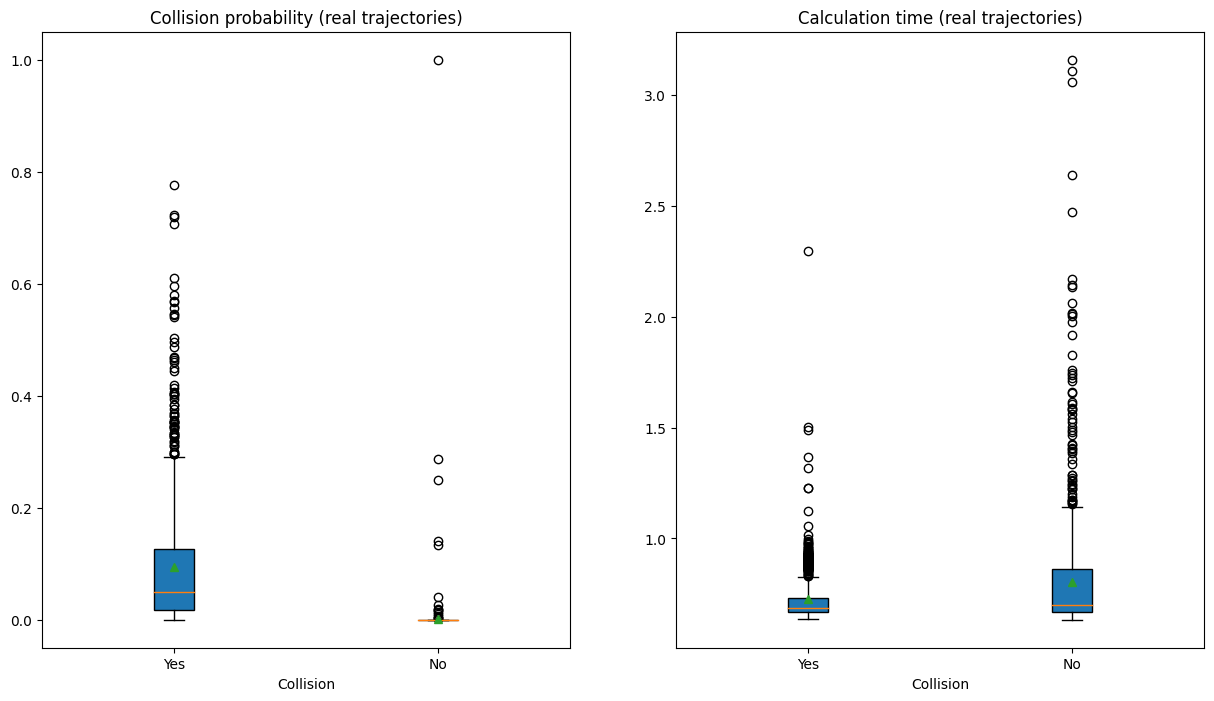

In [ ]:
# RC
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Collision probability (real trajectories)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Calculation time (real trajectories)")
ax[1].set_xlabel("Collision")
plt.show()


### N = 350

In [ ]:
SAMPLES=350

col_array = np.empty((0, 5))
# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Non collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]
  y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
  y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_350.csv")

df_collision_prob_350 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_350.to_csv(PROB_FILE, index=False)
df_collision_prob_350.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2892.0,2940.0,1.100922,0.182857,1.0
1,3850.0,3849.0,1.058096,0.045714,1.0
2,7638.0,7590.0,1.081024,0.140000,1.0
3,970.0,1160.0,1.047849,0.048571,1.0
4,3859.0,3803.0,1.272998,0.045714,1.0


In [ ]:
PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob_real_350.csv")
df_collision_prob_350 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = df_collision_prob_350[df_collision_prob_350['collision'] == 1]
no_collisions = df_collision_prob_350[df_collision_prob_350['collision'] == 0]


print("Average collision probability for collisions: {}"
      .format(np.mean(collisions['probability'])))
print("Average collision probability for non-collisions: {}"
      .format(np.mean(no_collisions['probability'])))

print("Average execution time for collisions: {}"
      .format(np.mean(collisions['execution_time'])))
print("Average execution time for non-collisions: {}"
      .format(np.mean(no_collisions['execution_time'])))
print("Average execution time: {}"
      .format(np.mean(df_collision_prob_350['execution_time'])))

Average collision probability for collisions: 0.09417714285714282
Average collision probability for non-collisions: 0.0019228571428571422
Average execution time for collisions: 1.2235865993499755
Average execution time for non-collisions: 1.1768054814338684
Average execution time: 1.200196040391922


## 2.3 Collision probability in the predicted dataset

### Best Model

#### N = 200

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import MultiTaskElasticNetCV

# Stack Regression
t = 5
num = 100
base_models = [MultiTaskElasticNetCV(),RANSACRegressor()]
meta_model = LinearRegression()
SAMPLES=200


col_array = np.empty((0, 5))

# Collisions
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]

  # Train1
  vehicle_train1 = df_scaled[df_scaled['vehicle_id']==v1_id].iloc[:-t]
  # np array1
  dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  y_v1 = minmaxscaler.inverse_transform(pred_coor1.reshape(-1, 3))

  # Train2
  vehicle_train2 = df_scaled[df_scaled['vehicle_id']==v2_id].iloc[:-t]
  # np array1
  dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)
  y_v2 = minmaxscaler.inverse_transform(pred_coor2.reshape(-1, 3))
  try:
    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                          np.array([v1_id, v2_id, total_time, collision_prob, 1])))
  except ValueError:
    continue
# Non-collisions
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]

  # Train1
  vehicle_train1 = df_scaled[df_scaled['vehicle_id']==v1_id].iloc[:-t]
  # np array1
  dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  y_v1 = minmaxscaler.inverse_transform(pred_coor1.reshape(-1, 3))

  # Train2
  vehicle_train2 = df_scaled[df_scaled['vehicle_id']==v2_id].iloc[:-t]
  # np array2
  dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)
  y_v2 = minmaxscaler.inverse_transform(pred_coor2.reshape(-1, 3))

  try:
    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                          np.array([v1_id, v2_id, total_time, collision_prob, 0])))
  except ValueError:
    continue
MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob_scaled_pred_1_200.csv")
df_collision_prob_scaled_pred_1_200 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_scaled_pred_1_200.to_csv(PROB_FILE, index=False)

In [ ]:
MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(MODEL_FOLDER, "df_collision_prob_scaled_pred_1_200.csv")
collision_prob_scaled_pred_1_200 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = collision_prob_scaled_pred_1_200[collision_prob_scaled_pred_1_200['collision'] == 1]
no_collisions = collision_prob_scaled_pred_1_200[collision_prob_scaled_pred_1_200['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.017712712712712714
Probabilidad media de colision para las no-colisiones: 0.0026926926926926927
Tiempo medio de ejecuion para las colisiones: 0.47263256708780926
Tiempo medio de ejecuion para las no-colisiones: 0.4917797710563805


In [ ]:
collisions['probability'].describe()

count    999.000000
mean       0.017713
std        0.092790
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: probability, dtype: float64

In [ ]:
no_collisions['probability'].describe()

count    999.000000
mean       0.002693
std        0.044412
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.965000
Name: probability, dtype: float64

In [ ]:
collision_threshold = 0.01

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 91
Valores por debajo de la media en las colisiones: 908
Valores por encima de la media en las no-colisiones: 7
Valores por debajo de la media en las no-colisiones: 992


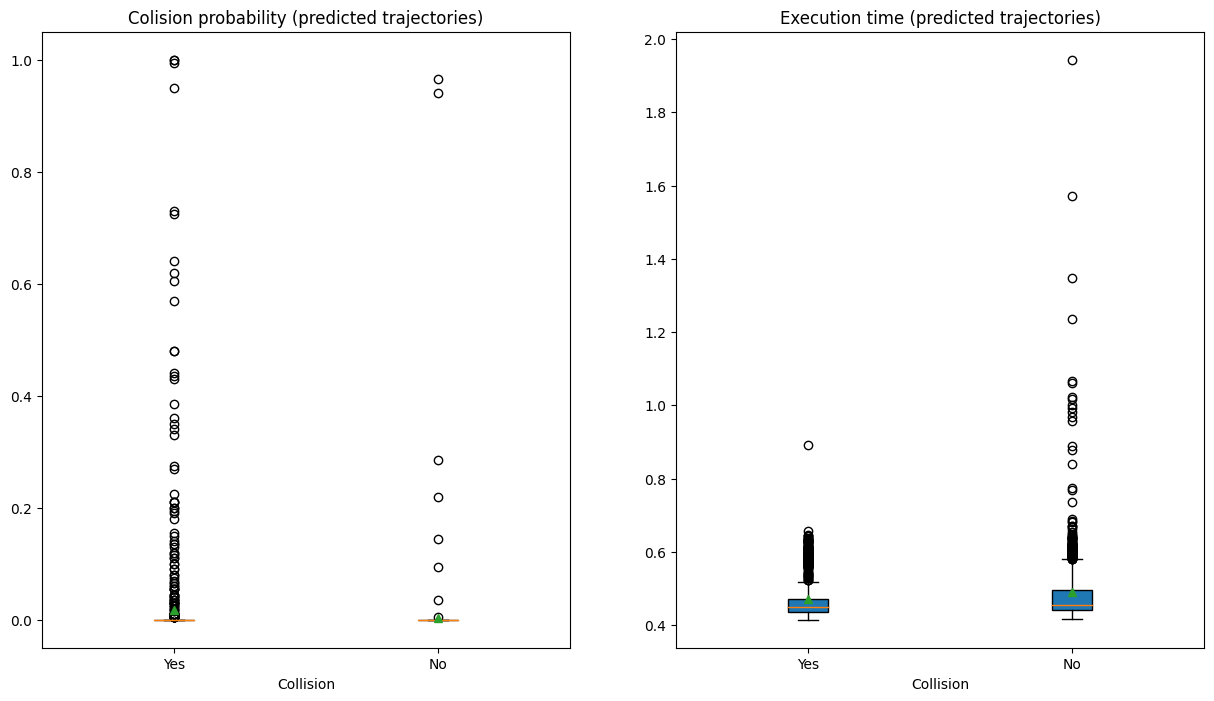

In [ ]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Colision probability (predicted trajectories)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Execution time (predicted trajectories)")
ax[1].set_xlabel("Collision")
plt.show()

#### N = 250

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import MultiTaskElasticNetCV

# Stack Regression
t = 5
num = 100
base_models = [MultiTaskElasticNetCV(),RANSACRegressor()]
meta_model = LinearRegression()
SAMPLES=250


col_array = np.empty((0, 5))

# Vehiculos que coinciden y colisionan
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]

  # Entreno1
  vehicle_train1 = df_scaled[df_scaled['vehicle_id']==v1_id].iloc[:-t]
  # np array1
  dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  y_v1 = minmaxscaler.inverse_transform(pred_coor1.reshape(-1, 3))

  # Entreno2
  vehicle_train2 = df_scaled[df_scaled['vehicle_id']==v2_id].iloc[:-t]
  # np array1
  dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)
  y_v2 = minmaxscaler.inverse_transform(pred_coor2.reshape(-1, 3))
  try:
    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                          np.array([v1_id, v2_id, total_time, collision_prob, 1])))
  except ValueError:
    continue
# Vehiculos que coinciden pero no colisionan
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]


  # METER Y_PRED:
  # Entreno1
  vehicle_train1 = df_scaled[df_scaled['vehicle_id']==v1_id].iloc[:-t]
  # np array1
  dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  y_v1 = minmaxscaler.inverse_transform(pred_coor1.reshape(-1, 3))

  # Entreno2
  vehicle_train2 = df_scaled[df_scaled['vehicle_id']==v2_id].iloc[:-t]
  # np array1
  dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)
  y_v2 = minmaxscaler.inverse_transform(pred_coor2.reshape(-1, 3))

  try:
    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                          np.array([v1_id, v2_id, total_time, collision_prob, 0])))
  except ValueError:
    continue
MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob_scaled_pred_1_250.csv")
df_collision_prob_scaled_pred_1_250 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_scaled_pred_1_250.to_csv(PROB_FILE, index=False)

In [ ]:
MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob_scaled_pred_1_250.csv")
df_collision_prob_scaled_pred_1_250 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = df_collision_prob_scaled_pred_1_250[df_collision_prob_scaled_pred_1_250['collision'] == 1]
no_collisions = df_collision_prob_scaled_pred_1_250[df_collision_prob_scaled_pred_1_250['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.017721721721721723
Probabilidad media de colision para las no-colisiones: 0.0029949949949949948
Tiempo medio de ejecuion para las colisiones: 0.5929520006055707
Tiempo medio de ejecuion para las no-colisiones: 0.5908747533181528


In [ ]:
collisions['probability'].describe()

count    999.000000
mean       0.017722
std        0.093706
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: probability, dtype: float64

In [ ]:
no_collisions['probability'].describe()

count    999.000000
mean       0.002995
std        0.045741
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.976000
Name: probability, dtype: float64

In [ ]:
collision_threshold = 0.008

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 90
Valores por debajo de la media en las colisiones: 909
Valores por encima de la media en las no-colisiones: 7
Valores por debajo de la media en las no-colisiones: 992


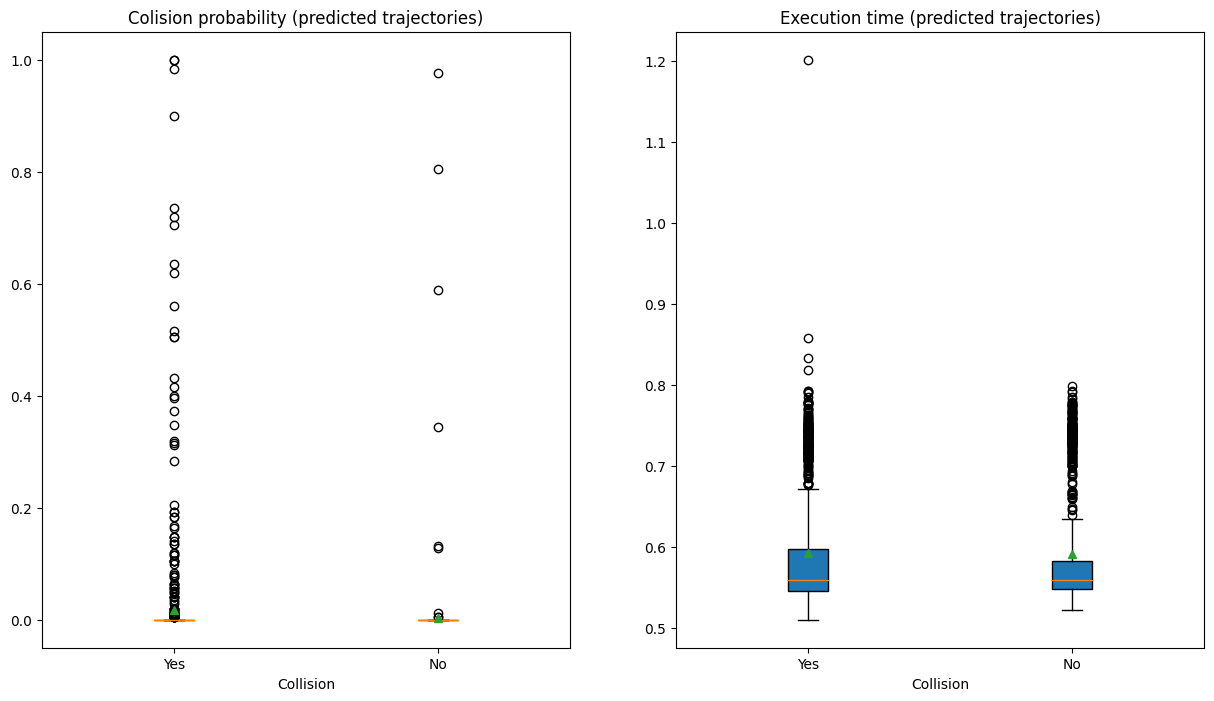

In [ ]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Colision probability (predicted trajectories)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Execution time (predicted trajectories)")
ax[1].set_xlabel("Collision")
plt.show()

#### N = 300

In [ ]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import MultiTaskElasticNetCV

# Stack Regression
t = 5
num = 100
base_models = [MultiTaskElasticNetCV(),RANSACRegressor()]
meta_model = LinearRegression()
SAMPLES=300

col_array = np.empty((0, 5))

# Vehiculos que coinciden y colisionan
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]

  # Entreno1
  vehicle_train1 = df_scaled[df_scaled['vehicle_id']==v1_id].iloc[:-t]
  # np array1
  dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  y_v1 = minmaxscaler.inverse_transform(pred_coor1.reshape(-1, 3))

  # Entreno2
  vehicle_train2 = df_scaled[df_scaled['vehicle_id']==v2_id].iloc[:-t]
  # np array1
  dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)
  y_v2 = minmaxscaler.inverse_transform(pred_coor2.reshape(-1, 3))
  try:
    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                          np.array([v1_id, v2_id, total_time, collision_prob, 1])))
  except ValueError:
    continue
# Vehiculos que coinciden pero no colisionan
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]


  # METER Y_PRED:
  # Entreno1
  vehicle_train1 = df_scaled[df_scaled['vehicle_id']==v1_id].iloc[:-t]
  # np array1
  dat_train1 = np.array(vehicle_train1[['latitude(m)','longitude(m)','heading']])
  pred_coor1 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train1)
  y_v1 = minmaxscaler.inverse_transform(pred_coor1.reshape(-1, 3))

  # Entreno2
  vehicle_train2 = df_scaled[df_scaled['vehicle_id']==v2_id].iloc[:-t]
  # np array1
  dat_train2 = np.array(vehicle_train2[['latitude(m)','longitude(m)','heading']])
  pred_coor2 = fit_and_pred_stack_list(base_models, meta_model, t, num, dat_train2)
  y_v2 = minmaxscaler.inverse_transform(pred_coor2.reshape(-1, 3))

  try:
    start = time.time()
    collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
    total_time = time.time() - start
    col_array = np.vstack((col_array,
                          np.array([v1_id, v2_id, total_time, collision_prob, 0])))
  except ValueError:
    continue
MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob_scaled_pred_1_300.csv")
df_collision_prob_scaled_pred_1_300 = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob_scaled_pred_1_300.to_csv(PROB_FILE, index=False)

In [ ]:
MODEL_FOLDER = os.path.join("TFM", "implementation")
PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob_scaled_pred_1_300.csv")
df_collision_prob_scaled_pred_1_300 = pd.read_csv(PROB_FILE)

In [ ]:
collisions = df_collision_prob_scaled_pred_1_300[df_collision_prob_scaled_pred_1_300['collision'] == 1]
no_collisions = df_collision_prob_scaled_pred_1_300[df_collision_prob_scaled_pred_1_300['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.01772105438772105
Probabilidad media de colision para las no-colisiones: 0.002225558892225559
Tiempo medio de ejecuion para las colisiones: 0.8521517380341157
Tiempo medio de ejecuion para las no-colisiones: 0.7262148582660878


In [ ]:
collisions['probability'].describe()

count    999.000000
mean       0.017721
std        0.094158
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: probability, dtype: float64

In [ ]:
no_collisions['probability'].describe()

count    999.000000
mean       0.002226
std        0.039658
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.980000
Name: probability, dtype: float64

In [ ]:
collision_threshold = 0.01

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 91
Valores por debajo de la media en las colisiones: 908
Valores por encima de la media en las no-colisiones: 7
Valores por debajo de la media en las no-colisiones: 992


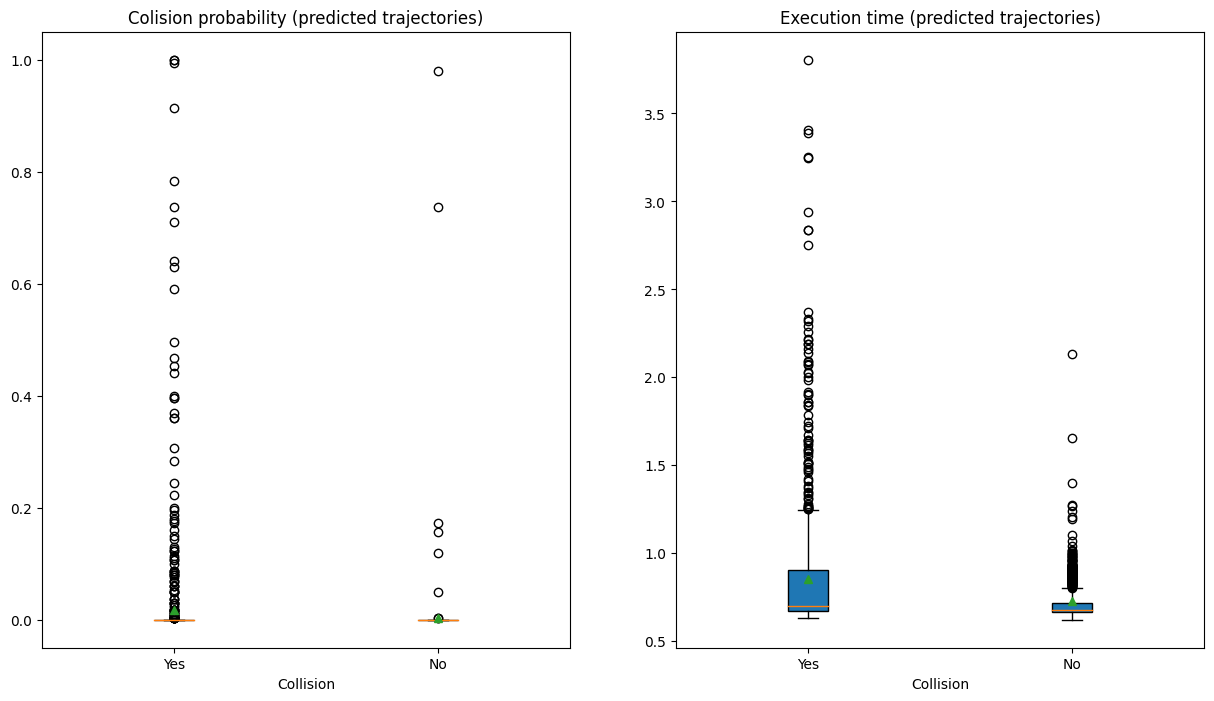

In [ ]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Colision probability (predicted trajectories)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Execution time (predicted trajectories)")
ax[1].set_xlabel("Collision")
plt.show()